In [122]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpopulation
from gwpopulation.models.redshift import MadauDickinsonRedshift
import bilby
import seaborn as sns
import pylab as plt
import os
import h5py
from sympy import symbols
import GWForge
import pycbc
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd

In [167]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
plot_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results')

In [83]:
gwpop_result = bilby.result.read_in_result(filename=os.path.join(project_dir, 
                                                                 'gwpopulation', 
                                                                 'BBH', 
                                                                 'gwpop_analysis_results',
                                                                 'Asharp-study-gwpop_result.hdf5'))
posterior = gwpop_result.posterior

In [4]:
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            '1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td.h5'), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

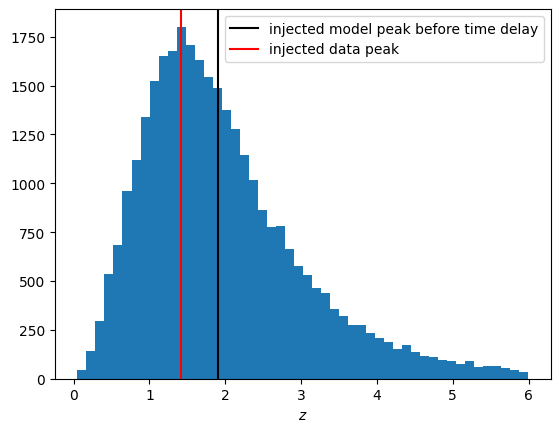

In [77]:
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(1.9, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [74]:
MDR_model = MadauDickinsonRedshift(z_max=8)

### Plot model at injection params vs median params

In [84]:
injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                         'after_time_delay':{'z_peak':inj_z_peak}}
median_hyper_params = {'gamma':np.median(posterior['gamma']), 
                       'kappa':np.median(posterior['kappa']), 
                       'z_peak':np.median(posterior['z_peak'])}

In [86]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 8, 0.01)
posterior_median_prob_arr = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params)

Text(0.5, 0, '$z$')

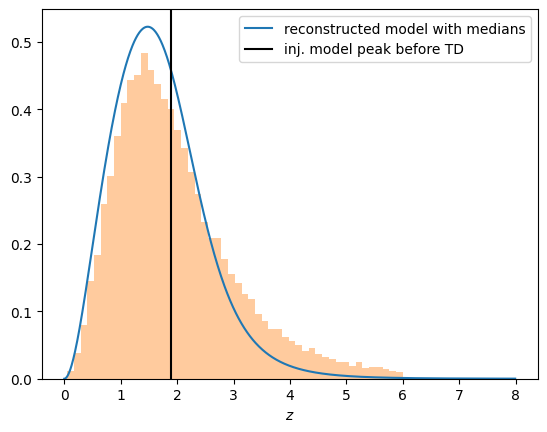

In [105]:
#plt.plot(injected_redshift[sort_idx], inj_prob_arr[sort_idx])
plt.plot(z_grid, posterior_median_prob_arr, label='reconstructed model with medians')
plt.hist(injected_redshift, bins=50, density=True, alpha=0.4);
#plt.plot(injected_redshift[sort_idx], 0.06*MDR_model.psi_of_z(injected_redshift, **injected_hyper_params['before_time_delay'])[sort_idx])
plt.axvline(1.9, c='k', label='inj. model peak before TD')
#plt.axvline(inj_z_peak, c='r', label='inj. data peak')
#plt.axvline(median_hyper_params['z_peak'], c='g')
plt.legend()
plt.xlabel('$z$')

### Plot posterior bands

In [160]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [161]:
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

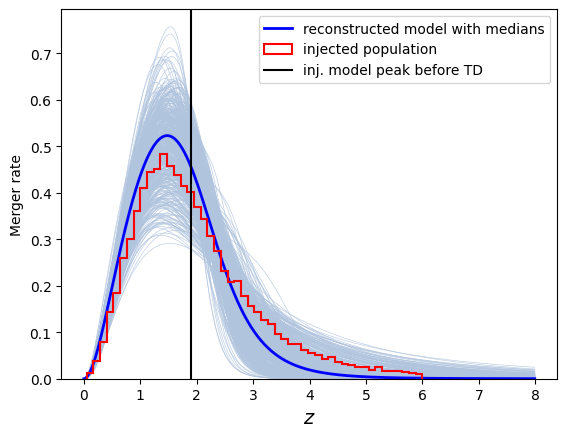

In [168]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr, label='reconstructed model with medians', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.axvline(1.9, c='k', label='inj. model peak before TD')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('Merger rate')
plt.savefig(os.path.join(plot_dir, 'reconstructed_z.pdf'))